############## THIS MODEL HASN'T BEEN TRAINED, ONLY THE TRAIN MODEL FROM 'WOOD' DATASET WAS APPLIED HERE 

Import libraries, check your DataFrame

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import sklearn

In [2]:
new_data = pd.read_csv('/content/glass.csv')
new_data = new_data.drop(columns=new_data.columns[0])

In [3]:
new_data.describe()

,VOL,AREA_F,APT_NUM,ST_NUM,KREIS,ZIPCODE,YOC,GLASS
count,184.000000,184.00000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,1615.282609,156.51087,4.918478,4.673913,7.505435,8042.809783,1941.005435,4.035598
std,768.527395,46.82370,2.947424,1.014740,2.797339,17.622071,12.227130,2.955217
min,226.000000,50.00000,1.000000,1.000000,2.000000,8003.000000,1904.000000,0.030000
25%,1084.250000,131.75000,2.000000,4.000000,6.000000,8046.000000,1932.000000,1.310000
50%,1524.000000,166.00000,6.000000,5.000000,7.500000,8048.000000,1942.500000,3.925000
75%,2104.250000,186.25000,6.250000,5.000000,10.000000,8053.000000,1950.000000,5.640000
max,3800.000000,271.00000,13.000000,7.000000,12.000000,8057.000000,1972.000000,12.500000


One-hot encode of categorical data


In [4]:
new_data['KREIS'] = new_data['KREIS'].astype('category')
new_data['ZIPCODE'] = new_data['ZIPCODE'].astype('category')
# One-hot encode the data using pandas get_dummies
new_data = pd.get_dummies(new_data)
print
print(new_data.columns)
print(new_data.shape)

Index(['VOL', 'AREA_F', 'APT_NUM', 'ST_NUM', 'YOC', 'GLASS', 'KREIS_2',
       'KREIS_3', 'KREIS_4', 'KREIS_6', 'KREIS_7', 'KREIS_8', 'KREIS_9',
       'KREIS_10', 'KREIS_11', 'KREIS_12', 'ZIPCODE_8003', 'ZIPCODE_8004',
       'ZIPCODE_8006', 'ZIPCODE_8008', 'ZIPCODE_8032', 'ZIPCODE_8038',
       'ZIPCODE_8044', 'ZIPCODE_8045', 'ZIPCODE_8046', 'ZIPCODE_8047',
       'ZIPCODE_8048', 'ZIPCODE_8049', 'ZIPCODE_8050', 'ZIPCODE_8051',
       'ZIPCODE_8052', 'ZIPCODE_8053', 'ZIPCODE_8055', 'ZIPCODE_8057',
       'ROOF_F', 'ROOF_M', 'ROOF_O', 'ROOF_P', 'POC_1900 - 1919',
       'POC_1919 - 1945', 'POC_1946 - 1960', 'POC_1961 - 1970',
       'POC_1971 - 1980'],
      dtype='object')
(184, 43)


Split data into an hold-out TEST set (T) and train + validation set (TV)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

material = 'GLASS'

# labels as numpy array
Y=np.array(new_data[material])

#features as numpy array
X_list= new_data.drop(columns=material)
X = np.array(X_list)

#save headers for later
headers = list(X_list.columns)

X_TV, X_T, Y_TV, Y_T = train_test_split(X,Y,test_size = 0.15, random_state = 296) #this split, meaning, this random seed, has to be the same for all the models!

print(X_T, Y_T)

[[ 579   80    1 ...    0    0    0]
 [3030  205    8 ...    0    0    0]
 [ 461   63    1 ...    0    0    0]
 ...
 [1488  149    6 ...    1    0    0]
 [ 802  115    2 ...    1    0    0]
 [1579  184    4 ...    1    0    0]] [ 3.    5.53  2.5   0.92  3.95  9.05  7.99  0.44  2.97  4.89  0.57  0.72
  2.82  0.52  5.55  4.52 11.43 11.5   5.07  3.21  1.54  6.27  2.82  4.04
  4.58  3.99  4.41  0.54]


Apply parameters to the whole set (parameters tuned on the wood set)

In [6]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from statistics import mean

# Create the parameter grid based on the results of random search 
tv_rf = RandomForestRegressor(
    bootstrap = "True",
    n_estimators= 800,
    max_depth = 10,
    max_features = "sqrt",
    min_impurity_decrease = 0.01,
    min_samples_leaf = 1
 )


# evaluate the model
cv = StratifiedKFold(n_splits=10, shuffle = True, random_state=42)
mae_tr = cross_val_score(tv_rf, X_TV, Y_TV, scoring='neg_mean_absolute_error', cv=10, n_jobs=1)

# report performance
print('MAE:', (mean(mae_tr)*(-1), np.std(mae_tr)))

r2_tr = cross_val_score(tv_rf, X_TV, Y_TV, scoring='r2', cv=10, n_jobs=1)
print('R2', (mean(r2_tr), np.std(r2_tr)))



MAE: (1.4462138820375356, 0.2655330675984825)
R2 (0.3347516005750559, 0.2939093368323584)


Read results

[ 0.75829064  0.30483785  0.65189322  0.44065862  0.11008736  0.54763249
  0.05993799  0.59368642  0.04541197 -0.16492054]


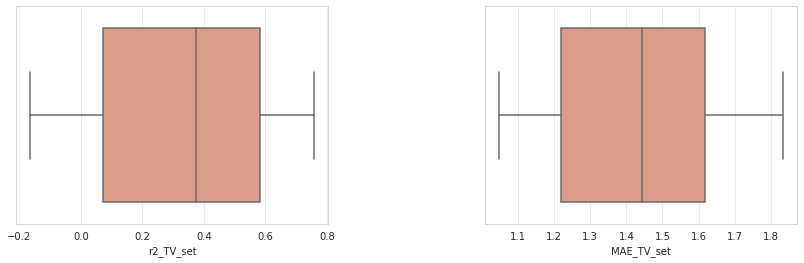

In [7]:
metrics_TV = pd.DataFrame(list(zip(r2_tr,mae_tr*(-1))), columns =['r2_TV_set', 'MAE_TV_set',])
print(r2_tr)
spacing = 0.5
f = plt.figure(figsize=(14,4))
gs = f.add_gridspec(1, 2)
gs.update(wspace = spacing, hspace = spacing)


with sns.axes_style("whitegrid", {"grid.color": ".9"}):
    ax = f.add_subplot(gs[0, 0])
    sns.boxplot(data=metrics_TV, x="r2_TV_set", color = "darksalmon")

with sns.axes_style("whitegrid", {"grid.color": ".9"}):
    ax = f.add_subplot(gs[0, 1])
    sns.boxplot(data=metrics_TV, x="MAE_TV_set", color = "darksalmon")


Fitted vs Actual plot 

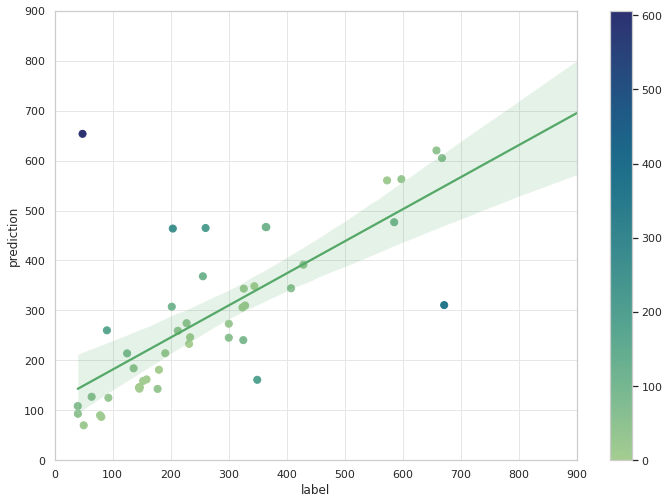

In [ ]:
# Visualising the Random Forest Regression results
predictions = t_rf.predict(X)
mae = np.round(abs(Y - predictions))
d = {'label': Y, 'prediction': predictions, 'mae': mae}
plot = pd.DataFrame(data = d)
# plot absolute settings
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid", {"grid.color": ".9"})

points = plt.scatter(d["label"], d["prediction"], s=50, c=d["mae"], cmap="crest")
plt.colorbar(points)
plt.xlim(0, 900)
plt.ylim(0, 900)

sns.regplot(
    x="label", y="prediction", data=plot, scatter = False, color='g')
 

Absolute error in the test set plot

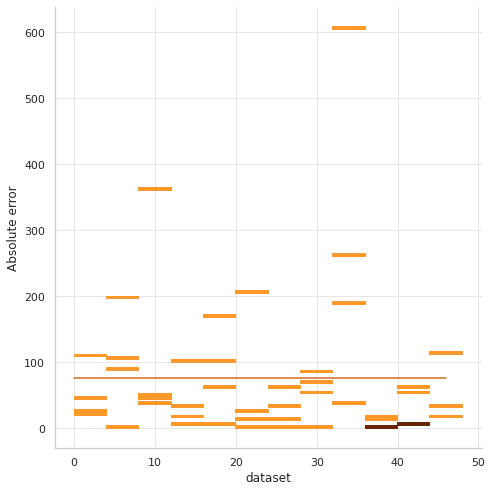

In [ ]:
# Visualising the Random Forest Regression results
n = X_T.shape[0]

sns.set_style("whitegrid", {"grid.color": ".9"})
numbers = np.array(list(range(0,int(n),+1)))

value = np.round(abs(Y_T - predictions))
d = {'Absolute error': value, 'dataset': numbers}
plot = pd.DataFrame(data = d)

sns.displot(data = plot, x="dataset", y="Absolute error", height=7,
    aspect=1, binwidth=(4, 4), cmap="YlOrBr")

sns.lineplot(data = plot, x="dataset", y=MAE, color = 'chocolate')

Feature importance

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.4 MB/s 


In [ ]:
import shap
from scipy.special import softmax
from sklearn.feature_selection import SelectFwe, chi2

def print_feature_importances_random_forest(random_forest_model):
    
    '''
    Prints the feature importances of a Random Forest model in an ordered way.
    random_forest_model -> The sklearn.ensemble.RandomForestRegressor or RandomForestClassifier trained model
    '''
    
    # Fetch the feature importances and feature names
    importances = rf.feature_importances_
    features = h_X
    
    # Organize them in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f}")

def print_feature_importances_shap_values(shap_values, features):
    
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''

    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    # Calculates the normalized version
    importances_norm = softmax(importances)

    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}

    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}

    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [ ]:
import shap
# Fits the explainer
explainer = shap.Explainer(t_rf.predict, X_list)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_T)

X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
Permutation explainer:   2%|▏         | 1/47 [00:00<?, ?it/s]X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted w

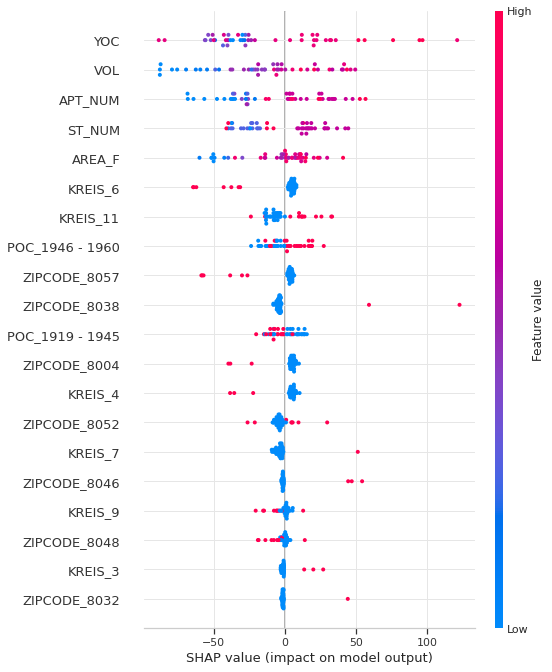

In [ ]:
shap.summary_plot(shap_values, feature_names = headers)